# Python Imports

In [1]:
import io
import os
import sys
from time import time
import numpy as np
from PIL import Image
import pandas as pd
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.express as px

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Control Constants

In [2]:
WIDTH = 500
HEIGHT = 500
MARGIN = 0
RADIUS = 5

WHITE ='#FFFFFF'
RED = '#FF0000'
DARK_RED = '#660000'
GREEN = '#00FF00'
BLUE = '#0000FF'
BLACK =  '#000000'
BACKGROUND = 'rgba(50,205,50)'

In [3]:
SEED = 1
np.random.seed(SEED)

In [4]:
LAYOUT = go.Layout(
    
    autosize=False,
    width=WIDTH+MARGIN,
    height=HEIGHT+MARGIN,
    plot_bgcolor=GREEN,
    paper_bgcolor=WHITE,
    margin=dict(l=MARGIN//2, r=MARGIN//2, t=MARGIN//2, b=MARGIN//2)
)
MARKER_SETTINGS = dict(size=RADIUS, color=RED, line=dict(width=2, color=RED))
print(LAYOUT)
print("Marker Settings: {}".format(MARKER_SETTINGS))

default_layout = go.Layout(dict(width=600, height=300, margin=dict(t=30,b=20,l=20,r=20)))

Layout({
    'autosize': False,
    'height': 500,
    'margin': {'b': 0, 'l': 0, 'r': 0, 't': 0},
    'paper_bgcolor': '#FFFFFF',
    'plot_bgcolor': '#00FF00',
    'width': 500
})
Marker Settings: {'size': 5, 'color': '#FF0000', 'line': {'width': 2, 'color': '#FF0000'}}


In [5]:
def build_layout(width=500, height=500):
    return go.Layout(
        autosize=False,
        width=width+MARGIN,
        height=height+MARGIN,
        plot_bgcolor=GREEN,
        paper_bgcolor=WHITE,
        margin=dict(l=MARGIN//2, r=MARGIN//2, t=MARGIN//2, b=MARGIN//2)
    )

def build_marker_settings(radius=RADIUS):
    return dict(size=radius, color=RED, line=dict(width=2, color=RED))

# Image Functions

In [6]:
def plotly_fig2array(fig):
    fig_bytes = fig.to_image(format='png')
    buffer = io.BytesIO(fig_bytes)
    img = Image.open(buffer)
    arr = np.asarray(img)
    return arr

def traceof(x, y, marker_settings=MARKER_SETTINGS):
    return go.Scatter(x=x, y=y, mode='markers', marker=marker_settings)

def lineof(x, y, name=""):
    return go.Scatter(x=x, y=y, mode='lines', name=name)

def figure(x, y, layout=LAYOUT, marker_settings=MARKER_SETTINGS):
    fig = go.Figure(layout=layout)
    fig.add_trace(traceof(x, y, marker_settings=marker_settings))
    return fig

def ImageOf(x, y, pixels_only=True, layout=LAYOUT, marker_settings=MARKER_SETTINGS):
    if pixels_only:
        return plotly_fig2array(figure(x, y, layout, marker_settings))
    else:  
        raw_img_data = plotly_fig2array(figure(x, y, layout, marker_settings))
        return raw_img_data, Image.fromarray(raw_img_data)

# Question One

Does the degree of correlation effect the number of samples needed to effectively display a linear trend in the data?


### Uniform Sampling Case

$$
p(x) = \frac{1}{b-a}
$$

### Normal Distribution

$$
p(x) = N(u, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{\frac{(x - u)^2}{\sigma^2}}
$$

In [4]:
n = 100000
a, b = 0, 1
midpoint = (b - a) / 2

x_uniform, x_normal = np.random.uniform(a, b, n), np.random.normal(size=n)
y_uniform, y_normal = np.random.uniform(a, b, n), np.random.normal(size=n)

In [5]:
trace_xu_yu = go.Scatter(x=x_uniform, y=y_uniform, mode='markers', marker=MARKER_SETTINGS)
trace_xu_yn = go.Scatter(x=x_uniform, y=y_normal,  mode='markers', marker=MARKER_SETTINGS)
trace_xn_yu = go.Scatter(x=x_normal,  y=x_uniform,  mode='markers', marker=MARKER_SETTINGS)
trace_xn_yn = go.Scatter(x=x_normal,  y=y_normal,   mode='markers', marker=MARKER_SETTINGS)

NameError: name 'MARKER_SETTINGS' is not defined

In [7]:
fig1 = go.Figure(layout=LAYOUT)
fig1.add_trace(trace_xu_yu)
xu_yu_img = plotly_fig2array(fig1)
print("R = ", np.corrcoef(x=x_uniform, y=y_uniform)[0, 1])
print("Output Shape: {}".format(xu_yu_img.shape))
Image.fromarray(xu_yu_img)

NameError: name 'trace_xu_yu' is not defined

R =  -0.0011858976685657201
Output Shape: (500, 500, 4)


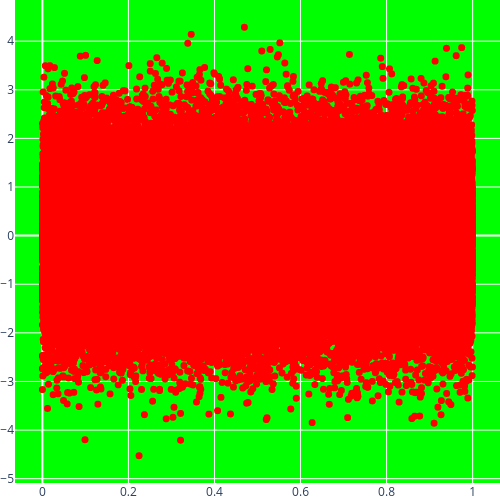

In [13]:
fig2 = go.Figure(layout=LAYOUT)
fig2.add_trace(trace_xu_yn)
xu_yn_img = plotly_fig2array(fig2)
print("R = ", np.corrcoef(x=x_uniform, y=y_normal)[0, 1])
print("Output Shape: {}".format(xu_yn_img.shape))
Image.fromarray(xu_yn_img)

R =  0.0059125346472255706
Output Shape:  (500, 500, 4)


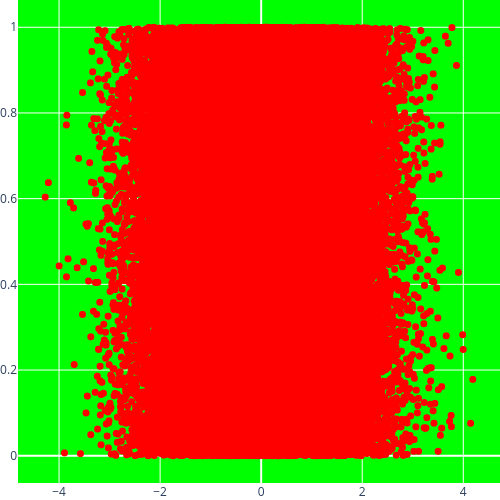

In [14]:
fig3 = go.Figure(layout=LAYOUT)
fig3.add_trace(trace_xn_yu)
xn_yu_img = plotly_fig2array(fig3)
print("R = ", np.corrcoef(x=x_normal, y=y_uniform)[0, 1])
print("Output Shape: ", xn_yu_img.shape)
Image.fromarray(xn_yu_img)

R =  0.010624768156196958
Output Shape:  (500, 500, 4)


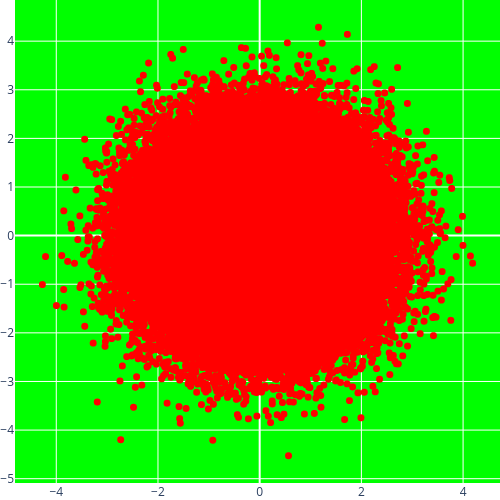

In [15]:
fig4 = go.Figure(layout=LAYOUT)
fig4.add_trace(trace_xn_yn)
xn_yn_img = plotly_fig2array(fig4)
print("R = ", np.corrcoef(x=x_normal, y=y_normal)[0, 1])
print("Output Shape: ", xn_yn_img.shape)
Image.fromarray(xn_yn_img)

Things to note. The correlatation between two vairables is the their shared percentage of shared determinants. For instance, smoking and lung cancer have a shared determinant of carcinogens which explains their observed correlation. So what the above plots are demonstrating is that independently operating distributions yield low correlation values.


A distribution or relation can take multiple arbitrary shapes. Note that a normal distribution is less sparse than a uniform distribution, it therefore consumes less 'space' then a uniform distribution.
For any dataset, there can be multiple distributions present. For a generic online sampler, we have no prior on what distribution will be observed. This is partly why uniform random sampling is so prevalent.

Let's take the persepctive of a data analyst looking to quick visaulize possible trends in the data. Assume the dataset is well over 1M data points so visualizaing all of them is impractical for interactive, exploratory uses.

1) What is the minimum number of samples needed to confidently capture a trend or conclude there is no trend in the data?

2) What is the number of samples needed in which updates to the plot yield no perceptable difference in final image?

Right now you have a generic Buffon Coin sampler which uses the parameters of the plot to specify an upper bound on the number of samples needed to display on a plot before overplotting occurs.

3) Can you this sampling methodolgy capture enough data to have a correlation or not?

# Image Metrics

In [9]:
def norm(x: np.array, y: np.array, p=2):
    if x.shape != y.shape:
        raise ValueError("Mismatch Input Element Shape. X-Shape: {} != Y-Shape: {}", x.shape, y.shape)
    if p != 1 and p != 2:
        raise ValueError("Only Support L1 and L2 Norms. Input p = {}", p)
    return np.sqrt((np.sum(np.abs(x - y)**p)))

def epsilon(data):
    return np.linalg.norm(np.max(data, axis=0) - np.min(data, axis=0)) / 100

def kappa(S, X, epsilon):
    return np.exp(-(np.linalg.norm(X[:, None, :] - S[None, :, :], axis=-1)**2) / epsilon)

def vas_loss_fn(S, X, epsilon):
    return np.sum(1 / np.sum(kappa(X=X, S=S, epsilon=epsilon), axis=1))

def log_loss_ratio(S, X):
    return np.log10(np.divide(vas_loss_fn(X, S), vas_loss_fn(X, X)))

class Normal:

    def __init__(self, p=2):
        self.p = p

    def __call__(self, x: np.array, y: np.array):
        return norm(x=x, y=y, p=self.p)

    def __str__(self):
        if self.p == 2:
            return "Mean Squared Error"
        else:
            return "Manhatten"


class SSIM:

    def __init__(self, win_size=7, channel_axis=2):
        self.win_size = win_size
        self.channel_axis = channel_axis

    def __call__(self, x: np.array, y: np.array):
        return ssim(x, y, win_size=self.win_size, channel_axis=self.channel_axis)

    def __str__(self):
        return "SSIM"

class VAS:

    def __init__(self, full_data):
        self.epsilon = epsilon(full_data)

    def __call__(self, S: np.array, X: np.array):
        return vas_loss_fn(S=S, X=X, epsilon=self.epsilon)

    def __str__(self):
        return "VAS"

# Builder Functions

In [7]:
class Sample:
    def __init__(self, data, img):
        self.data = data
        self.img = img
        self.correlation = np.corrcoef(x=data[:, 0], y=data[:, 1])[0, 1]
    
    def __str__(self):
        return f"Sample {self.data.shape}. K = {len(self.data)}"

    def __len__(self):
        return len(self.data)

    def r(self):
        return self.correlation
    
    def x(self):
        return self.data[:, 0]

    def y(self):
        return self.data[:, 1]

    def image(self):
        return Image.fromarray(self.img)

def build_sample_space(size):
    return np.linspace(start=int(0.01 * size), stop=int(1.0 * size), num=100).astype(int)

def build_samples(full_data, sample_rates, layout=LAYOUT, marker_settings=MARKER_SETTINGS):
    samples = dict()
    for K in sample_rates:
        print(f'Building Sample {K} of {len(full_data)}')
        sample_data = full_data[np.random.permutation(len(full_data))[:K], :]
        sample_img = ImageOf(
            x=sample_data[:, 0], y=sample_data[:, 1], pixels_only=True,
            layout=layout, marker_settings=marker_settings)
        sample_instance = Sample(data=sample_data, img=sample_img)
        samples[len(sample_instance)] = sample_instance
    return samples

def distance(a, b, metric):
    if str(metric) == 'VAS':
        return metric(a.data, b.data)
    else:
        return metric(a.img, b.img)

# Evaluation Functions

In [8]:
def evaluate(samples, target, metric, verbose=False):
    distances = {}
    for sample in samples.values():

        if verbose:
            if str(metric) != 'VAS' or len(sample) <= 10000:
                print(f'Measuring {metric} for {sample} with respect to {target}')

        if str(metric) == 'VAS':
            distances[len(sample)] = metric(sample.data, target.data)
        else:
            distances[len(sample)] = metric(sample.img, target.img)
    return distances 

# Experiment 1

Lets start simple. Assume there is a linear trend $y=x$. The variable $x$ is normally distributed with $y$ normally distributed from it.


## Experiment 1 Data Preparation And Result Generation

In [16]:
N = int(1e5)
x = np.random.normal(size=N)
y = x + np.random.normal(size=N)
x_y_exp1 = np.concatenate((x[None, :].T, y[None, :].T), axis=1)
sample_space = build_sample_space(N)

print("")
print("Full Data Shape: ", x_y_exp1.shape)
print("")
print('Sample Space:\n', sample_space)


Full Data Shape:  (100000, 2)

Sample Space:
 [  1000   2000   3000   4000   5000   6000   7000   8000   9000  10000
  11000  12000  13000  14000  15000  16000  17000  18000  19000  20000
  21000  22000  23000  24000  25000  26000  27000  28000  29000  30000
  31000  32000  33000  34000  35000  36000  37000  38000  39000  40000
  41000  42000  43000  44000  45000  46000  47000  48000  49000  50000
  51000  52000  53000  54000  55000  56000  57000  58000  59000  60000
  61000  62000  63000  64000  65000  66000  67000  68000  69000  70000
  71000  72000  73000  74000  75000  76000  77000  78000  79000  80000
  81000  82000  83000  84000  85000  86000  87000  88000  89000  90000
  91000  92000  93000  94000  95000  96000  97000  98000  99000 100000]


In [17]:
samples_exp1 = build_samples(full_data=x_y_exp1, sample_rates=sample_space)

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [18]:
print(samples_exp1[N])
ground_truth_exp1 = samples_exp1[N]

Sample (100000, 2). K = 100000


In [28]:
ssim_metric = SSIM()
rmse, manhat = Normal(p=2), Normal(p=1)

In [21]:
r_scores_exp1          = np.array([s.r() for s in samples_exp1.values()])
manhat_distances_exp1  = evaluate(samples_exp1,  ground_truth_exp1, manhat)
rmse_distances_exp1    = evaluate(samples_exp1,  ground_truth_exp1, rmse)
ssim_distances_exp1    = evaluate(samples_exp1 , ground_truth_exp1, ssim_metric)

## Experiment 1 Correlation Notes

The correlations are well bounded over near the true correlation over the entire sample space. The correlation is well bounded at 10 percent of the data.

Somewhere between a 1% and 10% of the data. Our correlation measurements converge with +/- 0.01 of the true correlation. So for trend analysis we should never go above 10% sample
spaces. We should try and derive an objective images function which mathces this expected behavior between 1 and 10 percent of the data.

In [22]:
r_line_exp1 = go.Figure(lineof(x=sample_space, y=r_scores_exp1), layout=default_layout)
r_line_exp1

## Experiment 1 Distance Notes


For all three distance metrics, the similarity fails to reduce significantly between 10 and 50 percent of the data sampled. The correlation, however is stabile at 10 percent suggesing that further sampling beyound this point is unwarrantd assuming the analyst's task is linear correlation. As we approach high sample rates, futher reductions in similarity are observed while the measure correlation remains constant. This indicates that past 10 percent sample rates, the distance metrics become sensitive to outlier data points. Outliers, however, are of limited importance to correlation estimation.

### Euclidean Distances

In [23]:
domain = np.array(list(manhat_distances_exp1.keys()))
x1 = np.array(list(manhat_distances_exp1.values()))
y1 = x1 / np.max(x1)
x2 = np.array(list(rmse_distances_exp1.values()))
y2 = x2 / np.max(x2)
x3 = 1 - np.array(list(ssim_distances_exp1.values()))
y3 = x3 / np.max(x3)

In [24]:
distance_lines_exp1 = go.Figure(layout=default_layout)

distance_lines_exp1.add_trace(lineof(x=sample_space, y=r_scores_exp1,                 name="Correlation"))
distance_lines_exp1.add_trace(lineof(x=list(manhat_distances_exp1.keys()),    y=y1,   name="Manhatten"))
distance_lines_exp1.add_trace(lineof(x=list(rmse_distances_exp1.keys()),      y=y2,   name="RMSE"))
distance_lines_exp1.add_trace(lineof(x=list(ssim_distances_exp1.keys()),      y=y3,   name="1 - SSIM"))

distance_lines_exp1.update_layout(
        title='Normalized Distance To Ground Truth', 
        xaxis_title='Sample Size',
        yaxis_title='Normalized Distance')

## Experiment 1 Image Analysis

The Stuctural Similarity Between A Sample Size of 1 Percent is aleady similar but sparse relative to the final image. This initial test suggests the bounds of sampling should be limited between 1 and 10 Percent.

### Sample Rate 1%

Manhat score @ 1000 / 100000 = 4467.922895485104
RMSE score @ 1000 / 100000 = 2293.7403950752578
SSIM score @ 1000 / 100000 = 0.6797033292661718


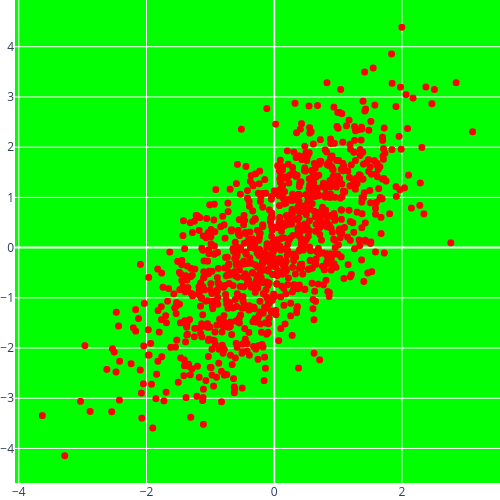

In [26]:
rate = int(0.01 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp1[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp1[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp1[rate]))
samples_exp1[rate].image().save("images/normal_corr_1.png")
samples_exp1[rate].image()

### Sample Rate 10%

Manhat score @ 10000 / 100000 = 3608.410453371401
RMSE score @ 10000 / 100000 = 2206.013145926379
SSIM score @ 10000 / 100000 = 0.7520429359533334


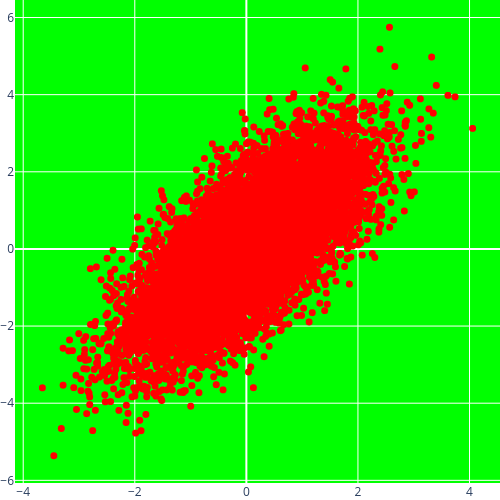

In [27]:
rate = int(0.10 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp1[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp1[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp1[rate]))
samples_exp1[rate].image().save("images/normal_corr_10.png")
samples_exp1[rate].image()

### Sample Rate 25%

Manhat score @ 25000 / 100000 = 3408.17942602792
RMSE score @ 25000 / 100000 = 2111.893699976398
SSIM score @ 25000 / 100000 = 0.7738162992338595


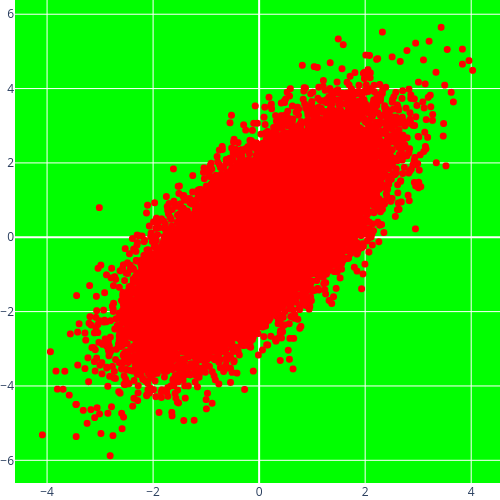

In [28]:
rate = int(0.25 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp1[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp1[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp1[rate]))
samples_exp1[rate].image().save("images/normal_corr_25.png")
samples_exp1[rate].image()

### Sample Rate 35%

Manhat score @ 35000 / 100000 = 3297.455837460147
RMSE score @ 35000 / 100000 = 1990.2052657954657
SSIM score @ 35000 / 100000 = 0.7961224667976876


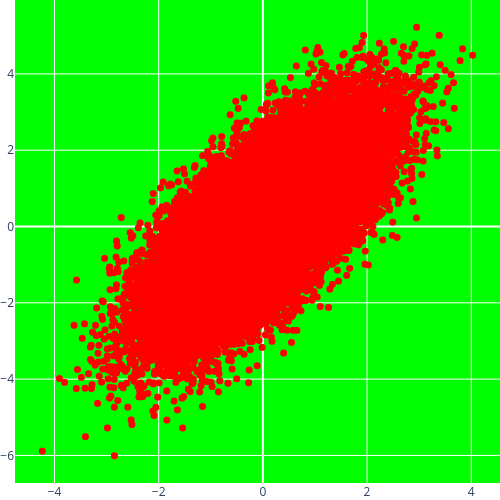

In [29]:
rate = int(0.35 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp1[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp1[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp1[rate]))
samples_exp1[rate].image().save("images/normal_corr_35.png")
samples_exp1[rate].image()

### Sample Rate 100%

In [30]:
rate = int(1.0 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp1[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp1[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp1[rate]))
samples_exp1[rate].image().save("images/Normal_VS_Normal.png")

Manhat score @ 100000 / 100000 = 0.0
RMSE score @ 100000 / 100000 = 0.0
SSIM score @ 100000 / 100000 = 1.0


### Outlier Illustration

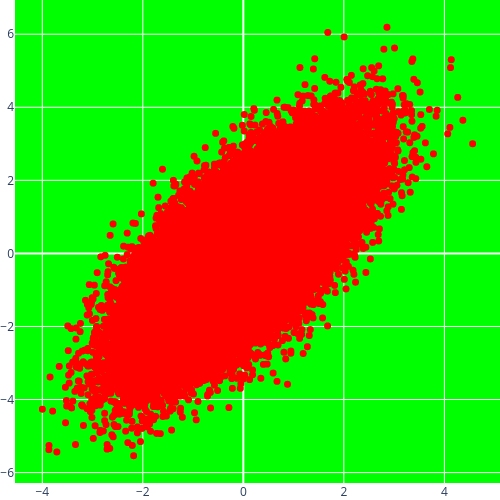

In [38]:
samples_exp1[63000].image()

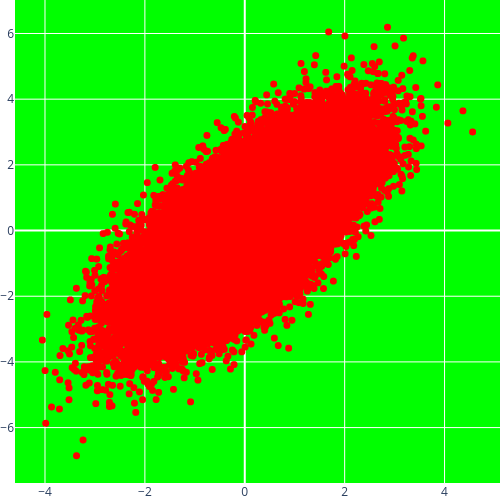

In [39]:
samples_exp1[65000].image()

## VAS Variance

Generate 50 Observations of VAS Measurements At Various Sizes. Get a normal curve around there possible values at each sample rate. This should smooth out the behaviour.

In [35]:
def observe_vas(sample_rate=0.1):
    vas_measurements = []
    for i in range(50):
        sample = x_y_exp1[np.random.permutation(len(x_y))[:int(sample_rate*len(x_y))], :]
        vas_measurements.append(vas(sample, x_y))
    vas_measurements = np.array(vas_measurements)
    return np.mean(vas_measurements), np.var(vas_measurements), np.std(vas_measurements)

### VAS Variance 0.1%

In [36]:
u, var, std = observe_vas(sample_rate=0.001)
print(f"Sample Rate 0.1 Percent. u = {u:.4}, var = {var:.4}, std = {std:.4}")

Sample Rate 0.1 Percent. u = 3.257e+72, var = 5.198e+146, std = 2.28e+73


### VAS Variance 1%

In [37]:
u, var, std = observe_vas(sample_rate=0.01)
print(f"Sample Rate 0.1 Percent. u = {u:.4}, var = {var:.4}, std = {std:.4}")

Sample Rate 0.1 Percent. u = 5.395e+33, var = 1.262e+69, std = 3.552e+34


### VAS Variance 10%

In [ ]:
u, var, std = observe_vas(sample_rate=0.1)
print(f"Sample Rate 0.1 Percent. u = {u:.4}, var = {var:.4}, std = {std:.4}")

Sample Rate 0.1 Percent. u = 1.331e+13, var = 1.52e+27, std = 3.899e+13


# Experiment 2 Normal Correlated With Uniform

## Experiment 2 Data Preparation and Result Generation

In [31]:
x = np.random.uniform(low=0.0, high=1.0, size=N)
y = x + np.random.normal(size=N)
x_y_exp2 = np.concatenate((x[None, :].T, y[None, :].T), axis=1)
print("Full Data Shape: ", x_y_exp2.shape)

Full Data Shape:  (100000, 2)


In [32]:
samples_exp2 = build_samples(full_data=x_y_exp2, sample_rates=sample_space)

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [33]:
print(samples_exp2[N])
ground_truth_exp2 = samples_exp2[N]

Sample (100000, 2). K = 100000


In [34]:
vas_exp2 = VAS(full_data=x_y_exp2)

In [35]:
r_scores_exp2          = np.array([s.r() for s in samples_exp2.values()])
manhat_distances_exp2  = evaluate(samples_exp2,  ground_truth_exp2, manhat)
rmse_distances_exp2    = evaluate(samples_exp2,  ground_truth_exp2, rmse)
ssim_distances_exp2    = evaluate(samples_exp2 , ground_truth_exp2, ssim_metric)

## Experiment 2 Correlation Notes

Since the the entropy increases with the introduction of a noisier system via the uniform distribution, the correlation between X and Y was reduceds.  The same stability in correlation, however was observed after 10 percent sampling.

In [46]:
r_line_exp2 = go.Figure(lineof(x=sample_space, y=r_scores_exp2), layout=default_layout)
r_line_exp2

## Experiment 2 Distance Notes

Similar behaviour as in experiment 1. The correlation converges @ 10% samples rate. The rate of decrease in distance slows after 10% but is not flat. Most likely, the more random the sample, the more steady the decrease in distance.

VAS is more stable on (on log scale past 1 percent of the data.)

### Euclidean Distances

In [36]:
domain = np.array(list(manhat_distances_exp2.keys()))
x1 = np.array(list(manhat_distances_exp2.values()))
y1 = x1 / np.max(x1)
x2 = np.array(list(rmse_distances_exp2.values()))
y2 = x2 / np.max(x2)
x3 = 1 - np.array(list(ssim_distances_exp2.values()))
y3 = x3 / np.max(x3)

In [37]:
distance_lines = go.Figure(layout=default_layout)
distance_lines.add_trace(lineof(x=sample_space, y=r_scores_exp2, name="Correlation"))

distance_lines.add_trace(lineof(x=list(manhat_distances_exp2.keys()), y=y1, name="Manhatten"))
distance_lines.add_trace(lineof(x=list(rmse_distances_exp2.keys()),   y=y2, name="RMSE"))
distance_lines.add_trace(lineof(x=list(ssim_distances_exp2.keys()),   y=y3, name="1 - SSIM"))

distance_lines.update_layout(
    title='Normalized Distance To Ground Truth', 
    xaxis_title='Sample Size', 
    yaxis_title='Normalized Distance')

## Experiment 2 Image Analysis

Same sparsity result between 1 and 10 percent samples.

### Sample Rate 1%

Manhat score @ 1000 / 100000 = 5641.273083267642
RMSE score @ 1000 / 100000 = 2366.2523111452
SSIM score @ 1000 / 100000 = 0.6196795691533477


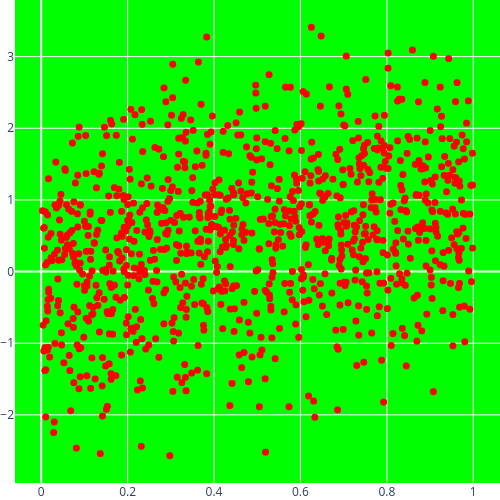

In [38]:
rate = int(0.01 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp2[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp2[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp2[rate]))
samples_exp2[rate].image()

### Sample Rate 1.0%

Manhat score @ 10000 / 100000 = 3850.2255778070976
RMSE score @ 10000 / 100000 = 2063.1454141674067
SSIM score @ 10000 / 100000 = 0.7500968426702674


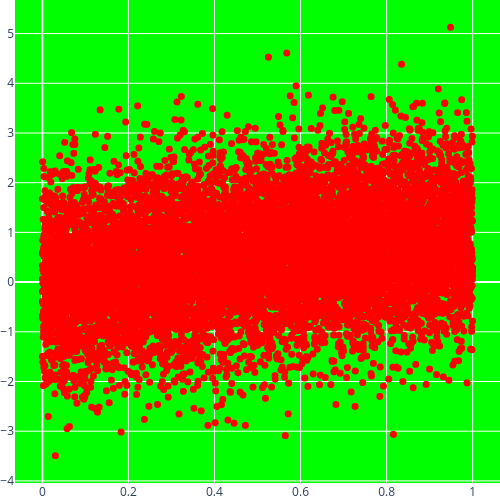

In [40]:
rate = int(0.1 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp2[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp2[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp2[rate]))
samples_exp2[rate].image()

### Sample Rate 50%

Manhat score @ 50000 / 100000 = 3092.361718816219
RMSE score @ 50000 / 100000 = 1836.697307669394
SSIM score @ 50000 / 100000 = 0.8267398837935036


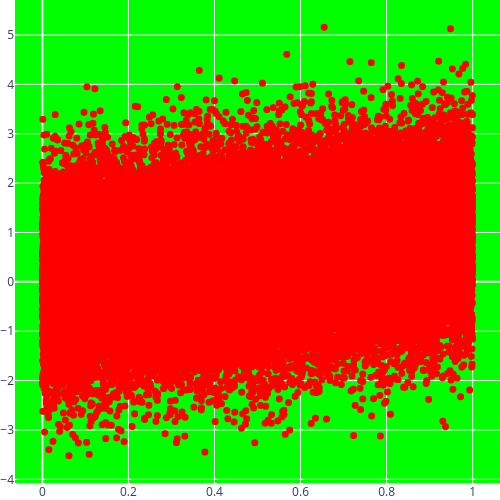

In [41]:
rate = int(0.5 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp2[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp2[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp2[rate]))
samples_exp2[rate].image()

### Sample Rate 100%

In [42]:
rate = int(1.0 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp2[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp2[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp2[rate]))
samples_exp2[rate].image().save("images/Normal_VS_Uniform.png")

Manhat score @ 100000 / 100000 = 0.0
RMSE score @ 100000 / 100000 = 0.0
SSIM score @ 100000 / 100000 = 1.0


# Experiment 3 Normal Uncorrelated Wtih Normal

## Experiment 3 Data Preparation and Result Generation

In [43]:
x = np.random.normal(size=N)
y = np.random.normal(size=N)
x_y_exp3 = np.concatenate((x[None, :].T, y[None, :].T), axis=1)

print("")
print("Full Data Shape: ", x_y_exp3.shape)


Full Data Shape:  (100000, 2)


In [44]:
samples_exp3 = build_samples(x_y_exp3, sample_rates=sample_space)

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [45]:
print(samples_exp3[N])
ground_truth_exp3 = samples_exp3[N]

Sample (100000, 2). K = 100000


In [47]:
r_scores_exp3          = np.array([s.r() for s in samples_exp3.values()])
manhat_distances_exp3  = evaluate(samples_exp3,  ground_truth_exp3, manhat)
rmse_distances_exp3    = evaluate(samples_exp3,  ground_truth_exp3, rmse)
ssim_distances_exp3    = evaluate(samples_exp3 , ground_truth_exp3, ssim_metric)

## Experiment 3 Correlation Notes

In [62]:
r_line_exp3 = go.Figure(lineof(x=sample_space, y=r_scores_exp3), layout=default_layout)
r_line_exp3.update_xaxes(type='log')
r_line_exp3

## Experiment 3 Distance Notes

### Euclidean Distances

In [48]:
domain = np.array(list(manhat_distances_exp3.keys()))
x1 = np.array(list(manhat_distances_exp3.values()))
y1 = x1 / np.max(x1)
x2 = np.array(list(rmse_distances_exp3.values()))
y2 = x2 / np.max(x2)
x3 = 1 - np.array(list(ssim_distances_exp3.values()))
y3 = x3 / np.max(x3)

In [121]:
distance_lines = go.Figure(layout=default_layout)

distance_lines.add_trace(lineof(x=sample_space, y=r_scores_exp3, name="Correlation"))

distance_lines.add_trace(lineof(x=list(manhat_distances_exp3.keys()), y=y1, name="Manhatten"))
distance_lines.add_trace(lineof(x=list(rmse_distances_exp3.keys()),   y=y2, name="RMSE"))
distance_lines.add_trace(lineof(x=list(ssim_distances_exp3.keys()),   y=y3, name="1 - SSIM"))

distance_lines.add_annotation(x=63000, y=0.9231, text="Outlier B", height=10, showarrow=True, arrowhead=1)
distance_lines.add_annotation(x=62000, y=0.3767, text="Outlier A", ay=75, showarrow=True, arrowhead=1)
distance_lines.update_layout(
    title='Normalized Distance To Ground Truth', 
    xaxis_title='Sample Size', 
    yaxis_title='Normalized Distance')

## Experiment 3 Image Analysis

### Sample Rate 1.0%

Manhat score @ 1000 / 100000 = 4932.827181242011
RMSE score @ 1000 / 100000 = 2429.79999176887
SSIM score @ 1000 / 100000 = 0.6320697461038424


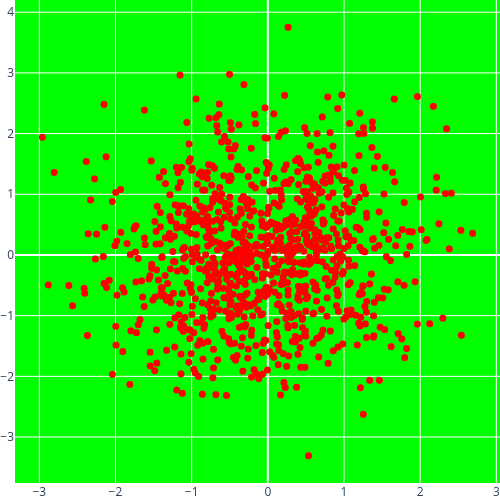

In [68]:
rate = int(0.01 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp3[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp3[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp3[rate]))
samples_exp3[rate].image()

### Sample Rate 10%

Manhat score @ 10000 / 100000 = 3879.6224043068933
RMSE score @ 10000 / 100000 = 2382.487775414598
SSIM score @ 10000 / 100000 = 0.7152916520635002


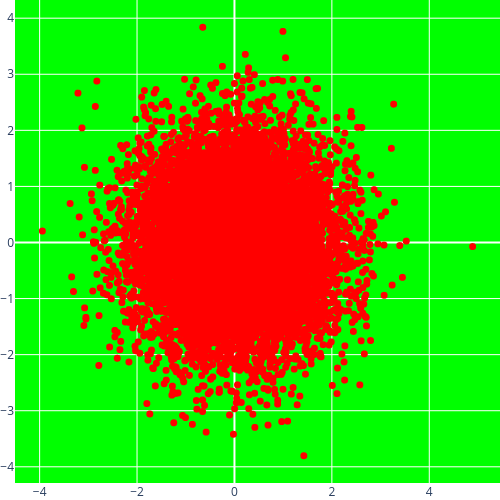

In [70]:
rate = int(0.1 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp3[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp3[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp3[rate]))
samples_exp3[rate].image()

### Sample Rate 50 %

Manhat score @ 50000 / 100000 = 3270.2056510256352
RMSE score @ 50000 / 100000 = 1824.1367821520403
SSIM score @ 50000 / 100000 = 0.812486258783077


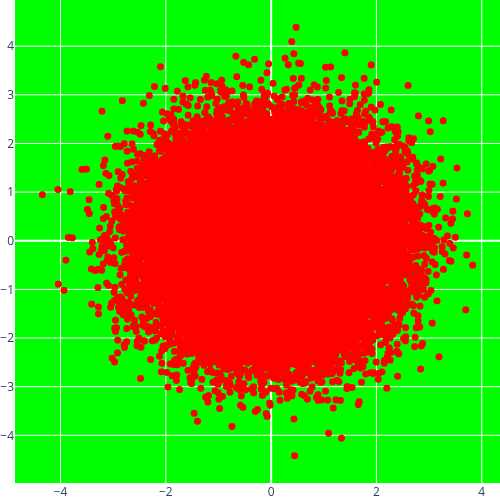

In [71]:
rate = int(0.5 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp3[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp3[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp3[rate]))
samples_exp3[rate].image()

### Sample Rate 100%

In [72]:
rate = int(1.0 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp3[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp3[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp3[rate]))
samples_exp3[rate].image().save('images/Normal_No_Correlation.png')

Manhat score @ 100000 / 100000 = 0.0
RMSE score @ 100000 / 100000 = 0.0
SSIM score @ 100000 / 100000 = 1.0


In [130]:
samples_exp3[62000].image().save('images/outlier_62k_a.png')

In [131]:
samples_exp3[63000].image().save('images/outlier_63k_b.png')

In [132]:
img_a, img_b = np.array(samples_exp3[63000].image()), np.array(samples_exp3[64000].image())
data_a, data_b = samples_exp3[63000].data, samples_exp3[64000].data

In [133]:
red_mask = np.array([255, 0, 0, 255])
green_mask = np.array([0, 255, 0, 255])
blue_mask = np.array([0, 0, 255, 255])

In [134]:
indices_match = np.where(np.all(img_a == img_b, axis=-1) & np.all(img_a == red_mask, axis=-1))
indices_a = np.where(np.all(img_a != img_b, axis=-1) & np.all(img_a == red_mask, axis=-1))
indices_b = np.where(np.all(img_a != img_b, axis=-1) & np.all(img_b == red_mask, axis=-1))
diff = img_b.copy()
diff[indices_match] = green_mask

In [135]:
diff_img = Image.fromarray(diff)

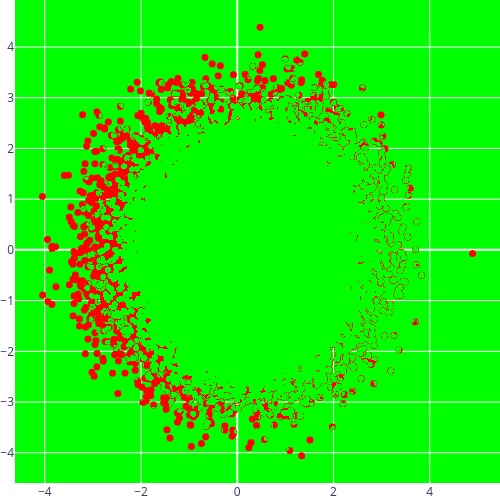

In [136]:
diff_img

In [137]:
diff_img.save('images/outlier_diff.png')

# Experiment 4 Uniform Uncorrelated with Uniform

## Experiment 4 Data Preparation and Result Generation

In [78]:
x = np.random.uniform(low=0, high=1, size=N)
y = np.random.uniform(low=0, high=1, size=N)
x_y_exp4 = np.concatenate((x[None, :].T, y[None, :].T), axis=1)
print("Full Data Shape: ", x_y_exp4.shape)

Full Data Shape:  (100000, 2)


In [79]:
samples_exp4 = build_samples(x_y_exp4, sample_rates=sample_space)

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [80]:
print(samples_exp4[N])
ground_truth_exp4 = samples_exp4[N]

Sample (100000, 2). K = 100000


In [82]:
r_scores_exp4          = np.array([s.r() for s in samples_exp4.values()])
manhat_distances_exp4  = evaluate(samples_exp4, ground_truth_exp4, manhat)
rmse_distances_exp4    = evaluate(samples_exp4, ground_truth_exp4, rmse)
ssim_distances_exp4    = evaluate(samples_exp4, ground_truth_exp4, ssim_metric)

## Experiment 4 Correlation Notes

In [84]:
r_line_exp4 = go.Figure(lineof(x=sample_space, y=r_scores_exp4), layout=default_layout)
r_line_exp4.update_xaxes(type='log')
r_line_exp4

## Experiment 4 Distance Notes

### Euclidean Distances

In [85]:
domain = np.array(list(manhat_distances_exp4.keys()))
x1 = np.array(list(manhat_distances_exp4.values()))
y1 = x1 / np.max(x1)
x2 = np.array(list(rmse_distances_exp4.values()))
y2 = x2 / np.max(x2)
x3 = 1 - np.array(list(ssim_distances_exp4.values()))
y3 = x3 / np.max(x3)

In [86]:
distance_lines = go.Figure(layout=default_layout)

distance_lines.add_trace(lineof(x=sample_space, y=r_scores_exp4, name="Correlation"))

distance_lines.add_trace(lineof(x=list(manhat_distances_exp4.keys()), y=y1, name="Manhatten"))
distance_lines.add_trace(lineof(x=list(rmse_distances_exp4.keys()),   y=y2, name="RMSE"))
distance_lines.add_trace(lineof(x=list(ssim_distances_exp4.keys()),   y=y3, name="1 - SSIM"))

distance_lines.update_layout(
    title='Normalized Distance To Ground Truth', 
    xaxis_title='Sample Size', 
    yaxis_title='Normalized Distance')

## Experiment 4 Image Analysis

### Sample Rate 1.0%

Manhat score @ 1000 / 100000 = 6652.070730231301
RMSE score @ 1000 / 100000 = 2297.435744476872
SSIM score @ 1000 / 100000 = 0.5613004269095037
VAS Score @ 1000 / 100000 = 2756.7526245723875


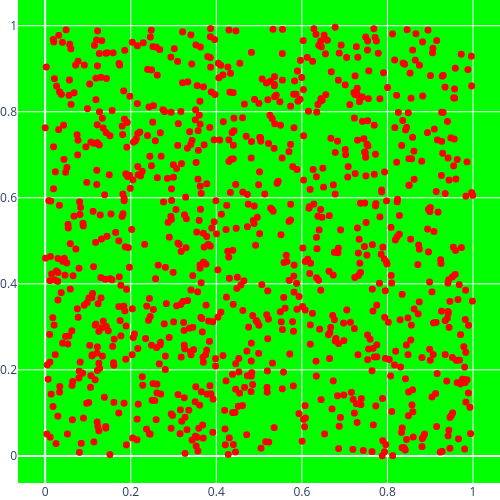

In [280]:
rate = int(0.01 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp4[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp4[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp4[rate]))
print("VAS Score @ {} / {} = {}".format(rate,    N, vas_distances_exp4[rate]))
samples_exp4[rate].image().save("images/Uniform_1.png")
samples_exp4[rate].image()

### Sample Rate 10%

Manhat score @ 10000 / 100000 = 3312.0555550896183
RMSE score @ 10000 / 100000 = 2327.6988636849055
SSIM score @ 10000 / 100000 = 0.6821020249009774
VAS Score @ 10000 / 100000 = 271.16955794607077


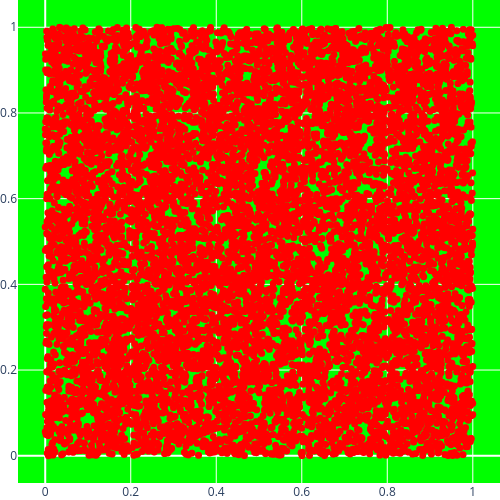

In [281]:
rate = int(0.1 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp4[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp4[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp4[rate]))
print("VAS Score @ {} / {} = {}".format(rate,    N, vas_distances_exp4[rate]))
samples_exp4[rate].image().save("images/Uniform_10.png")
samples_exp4[rate].image()

### Sample Rate 25.0%

Manhat score @ 25000 / 100000 = 1329.9221781743472
RMSE score @ 25000 / 100000 = 990.3216649149912
SSIM score @ 25000 / 100000 = 0.9418340246635367


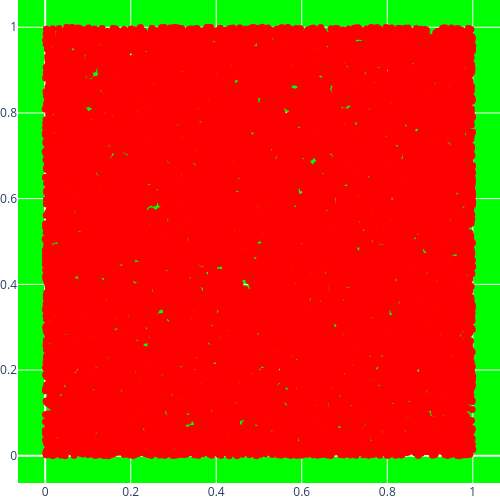

In [282]:
rate = int(0.25 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp4[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp4[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp4[rate]))
samples_exp4[rate].image().save("images/Uniform_25.png")
samples_exp4[rate].image()

### Sampel Rate 35%

In [283]:
rate = int(0.35 * N)
print("Manhat score @ {} / {} = {}".format(rate, N, manhat_distances_exp4[rate]))
print("RMSE score @ {} / {} = {}".format(rate,   N, rmse_distances_exp4[rate]))
print("SSIM score @ {} / {} = {}".format(rate,   N, ssim_distances_exp4[rate]))
samples_exp4[rate].image().save('images/Uniform_35.png')

Manhat score @ 35000 / 100000 = 857.820494042897
RMSE score @ 35000 / 100000 = 670.8591506419212
SSIM score @ 35000 / 100000 = 0.9824817673463818


# Experiment 5 Dedicated VAS

## Construct Datasets

In [78]:
SIZE = 10000

x_norm, y_norm = np.random.normal(size=SIZE), np.random.normal(size=SIZE)
x_uniform = np.random.uniform(low=0, high=1.0, size=SIZE)
y_uniform = np.random.uniform(low=0, high=1.0, size=SIZE)

temp1 = x_norm + y_norm
dataset1 = np.concatenate((x_norm[None, :].T, temp1[None, :].T), axis=1)

temp2 = x_uniform + y_norm
dataset2 = np.concatenate((x_uniform[None, :].T, temp2[None, :].T), axis=1)

dataset3 = np.concatenate((x_norm[None, :].T, y_norm[None, :].T), axis=1)
dataset4 = np.concatenate((x_uniform[None, :].T, y_uniform[None, :].T), axis=1)

sample_space_vas = build_sample_space(SIZE)

print("Shape Dataset 1: ", dataset1.shape)
print("Shape Dataset 2: ", dataset2.shape)
print("Shape Dataset 3: ", dataset3.shape)
print("Shape Dataset 4: ", dataset4.shape)
print("Sample Space:\n", sample_space_vas)

Shape Dataset 1:  (10000, 2)
Shape Dataset 2:  (10000, 2)
Shape Dataset 3:  (10000, 2)
Shape Dataset 4:  (10000, 2)
Sample Space:
 [  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000]


In [79]:
vas1, vas2, vas3, vas4 = VAS(dataset1), VAS(dataset2), VAS(dataset3), VAS(dataset4)

## Build Samples

In [80]:
vas1_samples = build_samples(dataset1, sample_space_vas)
vas2_samples = build_samples(dataset2, sample_space_vas)
vas3_samples = build_samples(dataset3, sample_space_vas)
vas4_samples = build_samples(dataset4, sample_space_vas)

Building Sample 100 of 10000
Building Sample 200 of 10000
Building Sample 300 of 10000
Building Sample 400 of 10000
Building Sample 500 of 10000
Building Sample 600 of 10000
Building Sample 700 of 10000
Building Sample 800 of 10000
Building Sample 900 of 10000
Building Sample 1000 of 10000
Building Sample 1100 of 10000
Building Sample 1200 of 10000
Building Sample 1300 of 10000
Building Sample 1400 of 10000
Building Sample 1500 of 10000
Building Sample 1600 of 10000
Building Sample 1700 of 10000
Building Sample 1800 of 10000
Building Sample 1900 of 10000
Building Sample 2000 of 10000
Building Sample 2100 of 10000
Building Sample 2200 of 10000
Building Sample 2300 of 10000
Building Sample 2400 of 10000
Building Sample 2500 of 10000
Building Sample 2600 of 10000
Building Sample 2700 of 10000
Building Sample 2800 of 10000
Building Sample 2900 of 10000
Building Sample 3000 of 10000
Building Sample 3100 of 10000
Building Sample 3200 of 10000
Building Sample 3300 of 10000
Building Sample 340

In [81]:
vas1_gt = vas1_samples[SIZE]
vas2_gt = vas2_samples[SIZE]
vas3_gt = vas3_samples[SIZE]
vas4_gt = vas4_samples[SIZE]

In [82]:
vas1_loss = evaluate(vas1_samples, vas1_gt, vas1, verbose=True)
vas2_loss = evaluate(vas2_samples, vas2_gt, vas2, verbose=True)
vas3_loss = evaluate(vas3_samples, vas3_gt, vas3, verbose=True)
vas4_loss = evaluate(vas4_samples, vas4_gt, vas4, verbose=True)

Measuring VAS for Sample (100, 2). K = 100 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (200, 2). K = 200 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (300, 2). K = 300 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (400, 2). K = 400 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (500, 2). K = 500 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (600, 2). K = 600 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (700, 2). K = 700 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (800, 2). K = 800 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (900, 2). K = 900 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (1000, 2). K = 1000 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (1100, 2). K = 1100 with respect to Sample (10000, 2). K = 10000
Measuring VAS for Sample (12

In [83]:
domain = np.array(list(vas1_loss.keys()))
v1 = np.array(list(vas1_loss.values()))
v2 = np.array(list(vas2_loss.values()))
v3 = np.array(list(vas3_loss.values()))
v4 = np.array(list(vas4_loss.values()))

In [153]:
vas_results = go.Figure(layout=default_layout)

vas_results.add_trace(lineof(x=domain, y=v1, name='Normal VS Normal'))
vas_results.add_trace(lineof(x=domain, y=v2, name='Normal VS Uniform'))
vas_results.add_trace(lineof(x=domain, y=v3, name='Normal Uncorrelated'))
vas_results.add_trace(lineof(x=domain, y=v4, name='Uniform Uncorrelated'))

vas_results.update_yaxes(type='log')

vas_results.add_annotation(x=1100, y=26, text="K=1100, Outlier B", ax=50, showarrow=True, arrowhead=1)

vas_results.update_layout(
        title='VAS Distance of Samples To Ground Truth', 
        xaxis_title='Sample Size', 
        yaxis_title='Distance')

vas_results

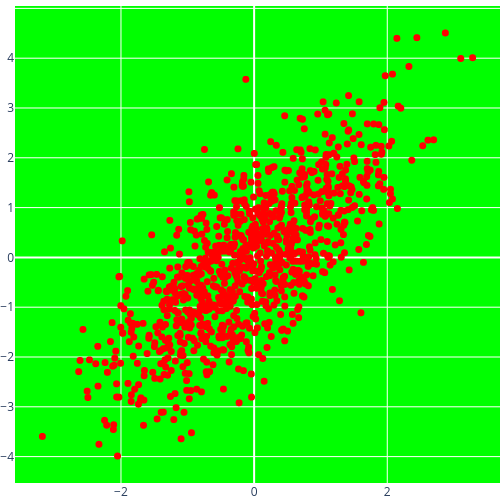

In [173]:
vas1_samples[1000].image().save('images/vas_outliers_1000_a.png')
vas1_samples[1000].image()

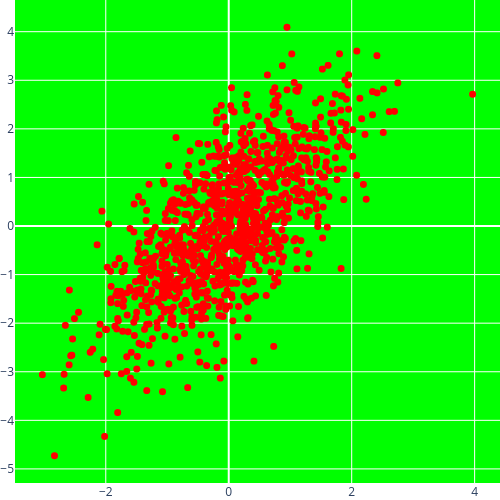

In [175]:
vas1_samples[1100].image().save('images/vas_outliers_1100_b.png')
vas1_samples[1100].image()

In [160]:
vas_img_a, vas_img_b = np.array(vas1_samples[1000].image()), np.array(vas1_samples[1100].image())
vas_data_a, vas_data_b = vas1_samples[1000].data, vas1_samples[1100].data

In [167]:
vas_indices_match = np.where(np.all(vas_img_a == vas_img_b, axis=-1) & np.all(vas_img_a == red_mask, axis=-1))
vas_diff_img = vas_img_b.copy()
vas_diff_img[vas_indices_match] = green_mask

In [176]:
diff_vas_img = Image.fromarray(vas_diff_img)
diff_vas_img.save("images/vas_outliers_diff.png")

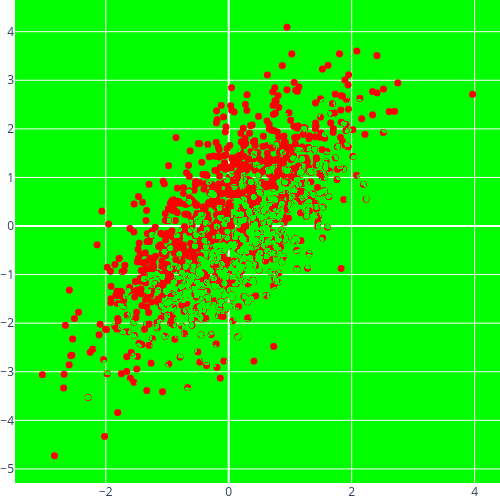

In [169]:
diff_vas_img

# Experiment 6 Different Grid Sizes (250, 250)

In [86]:
N = int(1e5)
x = np.random.normal(size=N)
y = x + np.random.normal(size=N)
x_y_exp1 = np.concatenate((x[None, :].T, y[None, :].T), axis=1)
sample_space = build_sample_space(N)

print("")
print("Full Data Shape: ", x_y_exp1.shape)
print("")
print('Sample Space:\n', sample_space)


Full Data Shape:  (100000, 2)

Sample Space:
 [  1000   2000   3000   4000   5000   6000   7000   8000   9000  10000
  11000  12000  13000  14000  15000  16000  17000  18000  19000  20000
  21000  22000  23000  24000  25000  26000  27000  28000  29000  30000
  31000  32000  33000  34000  35000  36000  37000  38000  39000  40000
  41000  42000  43000  44000  45000  46000  47000  48000  49000  50000
  51000  52000  53000  54000  55000  56000  57000  58000  59000  60000
  61000  62000  63000  64000  65000  66000  67000  68000  69000  70000
  71000  72000  73000  74000  75000  76000  77000  78000  79000  80000
  81000  82000  83000  84000  85000  86000  87000  88000  89000  90000
  91000  92000  93000  94000  95000  96000  97000  98000  99000 100000]


In [92]:
samples_small_plot = build_samples(
    full_data=x_y_exp1, 
    sample_rates=sample_space,
    layout=build_layout(width=250, height=250),
    marker_settings=build_marker_settings(radius=5))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [94]:
samples_mid_low_plot = build_samples(
    full_data=x_y_exp1, 
    sample_rates=sample_space,
    layout=build_layout(width=500, height=500),
    marker_settings=build_marker_settings(radius=5))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [95]:
samples_mid_high_plot = build_samples(
    full_data=x_y_exp1, 
    sample_rates=sample_space,
    layout=build_layout(width=750, height=750),
    marker_settings=build_marker_settings(radius=5))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [96]:
samples_large_plot = build_samples(
    full_data=x_y_exp1, 
    sample_rates=sample_space,
    layout=build_layout(width=1000, height=1000),
    marker_settings=build_marker_settings(radius=5))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [180]:
gt_small    = samples_small_plot[N]
gt_mid_low  = samples_mid_low_plot[N]
gt_mid_high = samples_mid_high_plot[N]
gt_large    = samples_large_plot[N]

In [179]:
manhat_distances_plot_small = evaluate(samples_small_plot, gt_small, manhat)
rmse_distances_plot_small   = evaluate(samples_small_plot, gt_small, rmse)
ssim_distances_plot_small   = evaluate(samples_small_plot, gt_small, ssim_metric)

In [181]:
manhat_distances_plot_mid_low = evaluate(samples_mid_low_plot, gt_mid_low, manhat)
rmse_distances_plot_mid_low   = evaluate(samples_mid_low_plot, gt_mid_low, rmse)
ssim_distances_plot_mid_low   = evaluate(samples_mid_low_plot, gt_mid_low, ssim_metric)

In [182]:
manhat_distances_plot_mid_high = evaluate(samples_mid_high_plot, gt_mid_high, manhat)
rmse_distances_plot_mid_high  = evaluate(samples_mid_high_plot, gt_mid_high, rmse)
ssim_distances_plot_mid_high  = evaluate(samples_mid_high_plot, gt_mid_high, ssim_metric)

In [183]:
manhat_distances_plot_large = evaluate(samples_large_plot, gt_large, manhat)
rmse_distances_plot_large  = evaluate(samples_large_plot, gt_large, rmse)
ssim_distances_plot_large = evaluate(samples_large_plot, gt_large, ssim_metric)

In [187]:
domain = np.array(list(samples_small_plot.keys()))

x1 = 1 - np.array(list(ssim_distances_plot_small.values()))
y1 = x1 / np.max(x1)

x2 = 1 - np.array(list(ssim_distances_plot_mid_low.values()))
y2 = x2 / np.max(x2)

x3 = 1 - np.array(list(ssim_distances_plot_mid_high.values()))
y3 = x3 / np.max(x3)

x4 = 1- np.array(list(ssim_distances_plot_large.values()))
y4 = x4 / np.max(x4)

In [191]:
distance_lines = go.Figure(layout=go.Layout(dict(width=600, height=300, margin=dict(t=30,b=20,l=20,r=20))))

distance_lines.add_trace(lineof(x=list(samples_small_plot.keys()), y=y1, name="250x250"))
distance_lines.add_trace(lineof(x=list(samples_small_plot.keys()), y=y2, name="500x500"))
distance_lines.add_trace(lineof(x=list(samples_small_plot.keys()), y=y3, name="750x750"))
distance_lines.add_trace(lineof(x=list(samples_small_plot.keys()), y=y3, name="1000x1000"))

distance_lines.update_layout(
    title='Normalized Distance To Ground Truth', 
    xaxis_title='Sample Size', 
    yaxis_title='Normalized Distance')

Spike Behaviour Persistant Accross All Plot Sizes

# Experiment 7 Changing Marker Radius

In [11]:
N = int(1e5)
x = np.random.normal(size=N)
y = x + np.random.normal(size=N)
marker_dataset = np.concatenate((x[None, :].T, y[None, :].T), axis=1)
sample_space = build_sample_space(N)

print("")
print("Full Data Shape: ", marker_dataset.shape)
print("")
print('Sample Space:\n', sample_space)


Full Data Shape:  (100000, 2)

Sample Space:
 [  1000   2000   3000   4000   5000   6000   7000   8000   9000  10000
  11000  12000  13000  14000  15000  16000  17000  18000  19000  20000
  21000  22000  23000  24000  25000  26000  27000  28000  29000  30000
  31000  32000  33000  34000  35000  36000  37000  38000  39000  40000
  41000  42000  43000  44000  45000  46000  47000  48000  49000  50000
  51000  52000  53000  54000  55000  56000  57000  58000  59000  60000
  61000  62000  63000  64000  65000  66000  67000  68000  69000  70000
  71000  72000  73000  74000  75000  76000  77000  78000  79000  80000
  81000  82000  83000  84000  85000  86000  87000  88000  89000  90000
  91000  92000  93000  94000  95000  96000  97000  98000  99000 100000]


In [12]:
samples_r1 = build_samples(
    full_data=marker_dataset, 
    sample_rates=sample_space,
    layout=build_layout(width=500, height=500),
    marker_settings=build_marker_settings(radius=1))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [13]:
samples_r3 = build_samples(
    full_data=marker_dataset, 
    sample_rates=sample_space,
    layout=build_layout(width=500, height=500),
    marker_settings=build_marker_settings(radius=3))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [14]:
samples_r5 = build_samples(
    full_data=marker_dataset, 
    sample_rates=sample_space,
    layout=build_layout(width=500, height=500),
    marker_settings=build_marker_settings(radius=5))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [15]:
samples_r7 = build_samples(
    full_data=marker_dataset, 
    sample_rates=sample_space,
    layout=build_layout(width=500, height=500),
    marker_settings=build_marker_settings(radius=7))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [16]:
samples_r9 = build_samples(
    full_data=marker_dataset, 
    sample_rates=sample_space,
    layout=build_layout(width=500, height=500),
    marker_settings=build_marker_settings(radius=9))

Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 11000 of 100000
Building Sample 12000 of 100000
Building Sample 13000 of 100000
Building Sample 14000 of 100000
Building Sample 15000 of 100000
Building Sample 16000 of 100000
Building Sample 17000 of 100000
Building Sample 18000 of 100000
Building Sample 19000 of 100000
Building Sample 20000 of 100000
Building Sample 21000 of 100000
Building Sample 22000 of 100000
Building Sample 23000 of 100000
Building Sample 24000 of 100000
Building Sample 25000 of 100000
Building Sample 26000 of 100000
Building Sample 27000 of 100000
Building Sample 28000 of 100000
Building Sample 29000 of 100000
Building Sample 30000 of 100000
Building Sample 31000 of 100000
Building Sample 3

In [20]:
gt_r1 = samples_r1[N]
gt_r3 = samples_r3[N]
gt_r5 = samples_r5[N]
gt_r7 = samples_r7[N]
gt_r9 = samples_r9[N]

In [29]:
manhat_distances_r1 = evaluate(samples_r1, gt_r1, manhat)
rmse_distances_r1   = evaluate(samples_r1, gt_r1, rmse)
ssim_distances_r1   = evaluate(samples_r1, gt_r1, ssim_metric)

In [30]:
manhat_distances_r3 = evaluate(samples_r3, gt_r3, manhat)
rmse_distances_r3   = evaluate(samples_r3, gt_r3, rmse)
ssim_distances_r3   = evaluate(samples_r3, gt_r3, ssim_metric)

In [34]:
manhat_distances_r5 = evaluate(samples_r5, gt_r5, manhat)
rmse_distances_r5   = evaluate(samples_r5, gt_r5, rmse)
ssim_distances_r5   = evaluate(samples_r5, gt_r5, ssim_metric)

In [32]:
manhat_distances_r7 = evaluate(samples_r7, gt_r7, manhat)
rmse_distances_r7   = evaluate(samples_r7, gt_r7, rmse)
ssim_distances_r7   = evaluate(samples_r7, gt_r7, ssim_metric)

In [35]:
manhat_distances_r9 = evaluate(samples_r9, gt_r9, manhat)
rmse_distances_r9   = evaluate(samples_r9, gt_r9, rmse)
ssim_distances_r9   = evaluate(samples_r9, gt_r9, ssim_metric)

In [43]:
domain = np.array(list(samples_r1.keys()))

x1 = 1 - np.array(list(ssim_distances_r1.values()))
y1 = x1 / np.max(x1)

x2 = 1 - np.array(list(ssim_distances_r3.values()))
y2 = x2 / np.max(x2)

x3 = 1 - np.array(list(ssim_distances_r5.values()))
y3 = x3 / np.max(x3)

x4 = 1 - np.array(list(ssim_distances_r7.values()))
y4 = x4 / np.max(x4)

x5 = 1 - np.array(list(ssim_distances_r9.values()))
y5 = x5 / np.max(x5)

In [46]:
r_results = go.Figure(layout=go.Layout(dict(width=600, height=300, margin=dict(t=30,b=20,l=20,r=20))))

r_results.add_trace(lineof(x=list(samples_r1.keys()), y=y1, name="r=1"))
r_results.add_trace(lineof(x=list(samples_r3.keys()), y=y2, name="r=3"))
r_results.add_trace(lineof(x=list(samples_r5.keys()), y=y3, name="r=5"))
r_results.add_trace(lineof(x=list(samples_r7.keys()), y=y4, name="r=7"))
r_results.add_trace(lineof(x=list(samples_r9.keys()), y=y5, name="r=9"))

r_results.update_layout(
    title='Normalized Distance To Ground Truth', 
    xaxis_title='Sample Size', 
    yaxis_title='Normalized Distance')

# Other

A note on this sample rate. It scales with the population size. Might be worth exploring how to update sampling rates to be smaller increments in extreeme cases.

In [ ]:
def correlations_over_samples(data, sample_rates):
    correlations = []
    for k in sample_rates:
        indices = np.random.permutation(k)
        correlation = np.corrcoef(x=data[indices, 0], y=data[indices, 1])[0, 1]
        correlations.append(correlation)
    return np.array(correlations)

In [ ]:
r_values = correlations_over_samples(data, sample_rates)

In [ ]:
line_fig = go.Figure(lineof(x=sample_rates, y=r_values))
line_fig

Ok. So now we know how the correlation is evolving over time for this simulated dataset. How does the difference in image quality change over sample rates?

Image quality is subjective. Human judgement is a HIGHLY imprecise as a measuring device. For now, use simple objective functions such as Euclidean distance to measure the differneces in images over time. It would also be helpful to have a ground truth image score as well at all times.


It would be cool if we could implement some sort of metric closely related to Visualization Aware Sampling (VAS) to meaure image quality since. VAS can imploy the property of locality and has been correlated with user studies. (Though I am always doubtful of the representativeness of the user studies in the HCI community.)


Also note, the beginning of the correlation curve is very noisy (normally distributed around the ideal correlation value). It might be worth representing this with a heat map distribution at the beginning.

Also note, it might be worth considering only the most outlying point on this correlation curve or any such curve.

#### Analysis

In [ ]:
def scores_over_samples(data, sample_rates, metric):

    target_image_data = ImageDataOf(x=data[:, 0], y=data[:, 1])

    correlations, image_diffs, images = [], [], []
    for k in sample_rates:

        print("Generating Scores For Sample Size: {} of {} ...".format(k, len(data)))

        indices = np.random.permutation(len(data))[:k]
        x_sample, y_sample = data[indices, 0], data[indices, 1]
        
        R = np.corrcoef(x=x_sample, y=y_sample)
        correlations.append(R[0, 1])

        sample_image_data = ImageDataOf(x=x_sample, y=y_sample)
        image_diffs.append(metric(sample_image_data, target_image_data))

        images.append(Image.fromarray(sample_image_data))


    return np.array(correlations), np.array(image_diffs), images

In [ ]:
op = SSIM()
reduced_sample_rates = [100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, len(data)]
r_scores, img_scores, scatter_plot_images = scores_over_samples(data, sample_rates=reduced_sample_rates, metric=op)

In [ ]:
print("Correlations: \n", r_scores)
print("Distance Scores: \n", img_scores)

In [ ]:
r_line = go.Figure(lineof(x=reduced_sample_rates, y=r_scores))
distance_line = go.Figure(lineof(x=reduced_sample_rates, y=img_scores))

In [ ]:
r_line

In [ ]:
distance_line

In [ ]:
print("Number Of Scatter Plot Images: ", len(scatter_plot_images))
scatter_plot_image_index = 8
scatter_plot_images[scatter_plot_image_index]

In [ ]:
ground_truth = np.array(scatter_plot_images[len(scatter_plot_images)-1])
samples = [np.array(scatter_plot_images[i]) for i in range(len(scatter_plot_images))]

print("Ground Truth Dimensions: ", ground_truth.shape)
for sample in samples:
    mse, similarity = (mean_squared_error(sample, ground_truth), ssim(sample, ground_truth, win_size=7, channel_axis=2))
    print("MSE = {}, SSIM = {}".format(mse, similarity))

#### Thoughts

How much would the score improve if you catured the outliers first for the above linear trend? This should at least get the scales right, I think.... :)

What does it mean to be an outlier? (MacroBase and other literature might have relavent insights here.) In this case, we could state that the points farthest from the center our outliers.
This kind of leads to the question of how to embed distance data into an arbitrary dataset. How do we project tabular data onto the 2D plane? Can that meta data be incorporated into an online data stream?
Instead of caputring outliers, maybe we should omit them?

For now, lets use our knowledge about this graph and cheat. We will test including the 50 most extreeme (farthest distance from the center and see how that affects the distance scores) and
exlude them and see how it effects the Euclidean distance bewteen the images. Including outliers at the expense of more representative data may create an unacceptable shift in correlation.

Even if you do include the outliers as priorities, does that help or hurt the analyst in the end? Remember, they are not really (should not be) interested in the absolute image quality. They
simply need a reliable correlation which safices for exploratory analysis.

Can we generate a distance metric on images that is correlated with the observed correlation in the graph?

##### Capture 50 Outliers

In [ ]:
def select_outliers(data, k=50):
    return data[np.argsort(np.linalg.norm(data, axis=1))[-k:], :]

In [ ]:
def scores_over_samples_outliers(data, sample_rates, metric):

    target_image_data = ImageDataOf(x=data[:, 0], y=data[:, 1])

    correlations, image_diffs, images = [], [], []
    outlier_indices = np.argsort(np.linalg.norm(data, axis=1))[-50:]
    outliers, inliers = np.take(data, outlier_indices, axis=0), np.delete(data, outlier_indices, axis=0)

    print(outliers.shape)
    print(inliers.shape)

    for k in sample_rates:

        print("Generating Scores For Sample Size: {} of {} ...".format(k, len(data)))

        indices = np.random.permutation(len(inliers))[:k]
        x_sample = np.concatenate((outliers[:, 0], inliers[indices, 0]))
        y_sample = np.concatenate((outliers[:, 1], inliers[indices, 1]))
        
        
        R = np.corrcoef(x=x_sample, y=y_sample)
        correlations.append(R[0, 1])

        sample_image_data = ImageDataOf(x=x_sample, y=y_sample)
        image_diffs.append(metric(sample_image_data, target_image_data))

        images.append(Image.fromarray(sample_image_data))


    return np.array(correlations), np.array(image_diffs), images

In [ ]:
norm_op = Normal(p=2)
reduced_sample_rates = [100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, len(data)]
r_scores_outliers, img_scores_outliers, scatter_plot_image_outliers = scores_over_samples_outliers(data, sample_rates=reduced_sample_rates, metric=norm)

In [ ]:
print("Correlations: \n", r_scores_outliers)
print("Distance Scores: \n", img_scores_outliers)

In [ ]:
r_line_outliers = go.Figure(lineof(x=reduced_sample_rates, y=r_scores))
distance_line_outliers = go.Figure(lineof(x=reduced_sample_rates, y=img_scores))

In [ ]:
r_line_outliers

In [ ]:
distance_line_outliers

In [ ]:
print("Number of Scatter Plot Outlier Images: ", len(scatter_plot_image_outliers))
selected_scatter_outlier_index = 0
scatter_plot_image_outliers[selected_scatter_outlier_index]

Lets observe the degradation in $r$ , correlation, as the variance in $y$ increases. For reference, here is the correlation formula. Remember, correlation measure the shared determinant between 2 variables. As the variance in $y$ increases, their are less predicitve factors encoded in $x$. In otherwords, based on our knowledge of $x$ are objective ignorance about $y$ increases if $y$ is more volatile around $x$. If you ground this in the case of father's height prediciting child height, this is stating that the child's height is increasing being influeced by other factors such as mother's height, enviroment, childhood diet, etc... 

In [ ]:
inputs = np.random.normal(size=10000)
dep_outputs = inputs + np.random.normal(scale = 10, size=10000)
ind_outputs = np.random.normal(size=10000)

R_dep = np.corrcoef(inputs, dep_outputs)
R_ind = np.corrcoef(inputs, ind_outputs)
print("R Dependent = ", R_dep[0][1])
print("R Independent = ", R_ind[0][1])


img_test_dep, img_test_ind = ImageOf(inputs, dep_outputs), ImageOf(inputs, ind_outputs)
img_test_dep_data, img_test_ind_data = ImageDataOf(inputs, dep_outputs), ImageDataOf(inputs, ind_outputs)

print("Image Difference B/W Independent and Dependence: ", norm(img_test_dep_data, img_test_ind_data))

In [ ]:
img_test_dep

In [ ]:
img_test_ind

# Full VAS Results

In [74]:
domain = np.array(list(vas_distances_exp4.keys()))
v1 = np.array(list(vas_distances_exp1.values()))
v2 = np.array(list(vas_distances_exp2.values()))
v3 = np.array(list(vas_distances_exp3.values()))
v4 = np.array(list(vas_distances_exp4.values()))

In [76]:
vas_line = go.Figure(layout=default_layout)
vas_line.add_trace(lineof(x=domain, y=v1, name='Normal_V_Normal'))
vas_line.add_trace(lineof(x=domain, y=v2, name='Normal_V_Uniform'))
vas_line.add_trace(lineof(x=domain, y=v3, name='Normal_No_Correlation'))
vas_line.add_trace(lineof(x=domain, y=v4, name='Uniform_No_Correlation'))
vas_line.update_yaxes(type='log')
vas_line.update_xaxes(type='log')
vas_line.update_layout(
    title='VAS Distances To Ground Truth', 
    xaxis_title='Sample Size', 
    yaxis_title='Distance')
vas_line

# VAS Visaulization Aware Sampling

The goal vector of the week was to implement a visualization objective function which was correlatated with user success. Use that objective function to evaluate where optimal samples reside when sampling.

This loss function as advertised by the authors maximized the visual fidelity of the scatter plot. Existing sampling approaches focus on minimizing the error of aggregate queries to a back-end server.

Specific Tasks Under Consideration...

1) Regression
2) Density Estimation
3) Clustering


Observations...

1) Visaulization Quality loss occurs since $S$ doesn not include all of $D$.
2) The loss at $x$ is reduced as the samples include points near $x$. 
3) If $D$ has projected datapoint @ $x$, then only a few $s \in S$ need to cover it. Diminishing marginal utility afterwards.

$$
\text{point-loss}(x) = \frac{1}{\sum_{s_i \in S} \kappa(x, s_i)}
$$

$$
\kappa(x, s_i) = \exp{\frac{-\| x - s_i \|^2}{\epsilon^2}}
$$ 

$$
Loss(S) = \int \text{point-loss}(x) \, dx = \int  \frac{1}{\sum_{s_i \in S} \kappa(x, s_i)} \, dx \approx 
$$


Full dataset $D$ of $N$ tuples $D = \{t_1, t_2, ... t_N\}$ where each tuple encodes the coordinate associated at the point displayed. So how do we encode the the positional data from a random data stream into an 2D scatter plot image? This paper was an offline sampler.

So we do have the ground truth, so we will know aprior where all the datapoint are projected into the 2D plane.


In [ ]:
x_y

array([[ 0.42667946,  0.35574855],
       [ 0.15492118,  0.01119748],
       [ 1.83934004,  1.73617311],
       ...,
       [-1.07282921, -1.2447011 ],
       [-1.03526924, -1.29602702],
       [-0.29786968, -1.83799956]])

In [ ]:
def epsilon(data):
    return np.linalg.norm(np.max(data, axis=0) - np.min(data, axis=0)) / 100

def kappa(X, S, epsilon):
    return np.exp(-(np.linalg.norm(X[:, None, :] - S[None, :, :], axis=-1)**2) / epsilon)

def loss_fn(X, S):
    return np.sum(1 / np.sum(kappa(X, S, epsilon=epsilon(X)), axis=1))

def log_loss_ratio(X, S):
    return np.log10(np.divide(loss_fn(X, S), loss_fn(X, X)))

In [ ]:
test_full = x_y[np.random.permutation(len(x_y))[:50], :]
test_sample1 = test_full[np.random.permutation(len(test_full))[:10], :]
test_sample2 = test_full[np.random.permutation(len(test_full))[:25], :]
print(test_full.shape)
print(test_sample1.shape)
print(test_sample2.shape)

(50, 2)
(10, 2)
(25, 2)


In [ ]:
losses, log_losses = [], []
for k in range(1, len(test_full)+1):
    sample = test_full[np.random.permutation(len(test_full))[:k], :]
    losses.append(loss_fn(test_full, sample))
    log_losses.append(log_loss_ratio(test_full, sample))

In [ ]:
loss_curve = go.Figure(lineof(np.arange(len(losses)), losses))
loss_curve.update_yaxes(type='log')
loss_curve

In [ ]:
log_loss_curve = go.Figure(lineof(np.arange(len(log_losses)), log_losses))
log_loss_curve